In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import cv2
import os
import skimage
from skimage import exposure, img_as_ubyte
from pathlib import Path
from skimage.feature import graycoprops, graycomatrix
import numpy as np 
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Concatenate, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import DenseNet121, VGG16, DenseNet201, MobileNetV2, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import graphviz
import pydot
import pandas as pd
import joblib


**Preprocessing**

Proses Preprocessing yang digunakan yaitu mengubah data citra menjadi grayscale, kemudian melakukan normalisasi sehingga range histogram berjarak 0 hingga 255. Normalisasi 0 hingga 255 dilakukan agar fitur tekstur dari kanker tidak hilang. Setelah citra dinormalisasi, dilakukan peningkatan kontras dengan teknik AHE (Adaptist Histogram Equalization). Dan terakhir dilakukan resize ukuran citra sebesar 512x512 untuk GLCM, untuk DenseNet dilakukan resize dengan ukuran 224x224. Hasil preprocess disimpan untuk data klasifikasi menggunakan GLCM.

In [6]:
main_directory = 'DataGLCM'
classes = os.listdir(main_directory)

for class_name in classes:
    class_directory = os.path.join(main_directory, class_name)
        # Memastikan direktori kelas ada
    if not os.path.isdir(class_directory):
        continue
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image_path = os.path.join(class_directory, filename)
            image = cv2.imread(image_path)
            
            # preprocess
            grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            img = grey/255
            #img = cv2.normalize(grey, None, 0, 255, cv2.NORM_MINMAX)
            imadapt = exposure.equalize_adapthist(img, clip_limit=0.02)
            imadapt = img_as_ubyte(imadapt)
            imadapt = cv2.resize(imadapt, (512, 512))

            
            #menyimpan hasil pada folder baru
            output_directory = os.path.join('D:\.Koding_Kuliah\.Koding_TA\path_output', class_name)
            os.makedirs(output_directory, exist_ok=True)
            output_path = os.path.join(output_directory, filename) 
            cv2.imwrite(output_path, imadapt)
            print(f"Hasil Tersimpan :{output_path}")
            

Hasil Tersimpan :D:\.Koding_Kuliah\.Koding_TA\path_output\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000000 (6).png
Hasil Tersimpan :D:\.Koding_Kuliah\.Koding_TA\path_output\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000005 (3).png
Hasil Tersimpan :D:\.Koding_Kuliah\.Koding_TA\path_output\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000005 (9).png
Hasil Tersimpan :D:\.Koding_Kuliah\.Koding_TA\path_output\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000008 (10).png
Hasil Tersimpan :D:\.Koding_Kuliah\.Koding_TA\path_output\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000009 (3).png
Hasil Tersimpan :D:\.Koding_Kuliah\.Koding_TA\path_output\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000009 (7).png
Hasil Tersimpan :D:\.Koding_Kuliah\.Koding_TA\path_output\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000013 (4).png
Hasil Tersimpan :D:\.Koding_Kuliah\.Koding_TA\path_output\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000013 (8).png
Hasil Tersimpan :D:\.Koding_Kuliah\.Koding_TA\path_output\adenocarcinom

In [ ]:
main_directory = 'DataGLCM'
classes = os.listdir(main_directory)

for class_name in classes:
    class_directory = os.path.join(main_directory, class_name)
    # Ensure class directory exists
    if not os.path.isdir(class_directory):
        continue
    
    for filename in os.listdir(class_directory):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image_path = os.path.join(class_directory, filename)
            image = cv2.imread(image_path)
            
            # Preprocess
            grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            img = cv2.convertScaleAbs(grey)  # Convert to CV_8UC1
            
            # Thresholding using Otsu's method
            _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            # Use morphological operations to remove small noises
            kernel = np.ones((5,5),np.uint8)
            binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
            binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

            # Find contours
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Check if contours were found
            if contours:
                # Sort contours by area and remove the largest one which is the background
                contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]

                # Find bounding boxes for each contour
                bounding_boxes = [cv2.boundingRect(c) for c in contours]

                # Create a mask with the lung regions
                mask = np.zeros_like(img)
                for box in bounding_boxes:
                    x, y, w, h = box
                    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

                # Apply the mask to the original image
                result = cv2.bitwise_and(image, image, mask=mask)
                
                # Ensure contours are not empty before finding bounding rect
                if contours:
                    x, y, w, h = cv2.boundingRect(np.vstack(contours))
                    cropped_lung = result[y:y+h, x:x+w]

                    # Equalize
                    imadapt = exposure.equalize_adapthist(cropped_lung, clip_limit=0.02)
                    imadapt = img_as_ubyte(imadapt)
                    imadapt = cv2.resize(imadapt, (512, 512))

                    # Save processed image to a new directory
                    output_directory = os.path.join('D:\.Koding_Kuliah\.Koding_TA\path_output2', class_name)
                    os.makedirs(output_directory, exist_ok=True)
                    output_path = os.path.join(output_directory, filename)
                    cv2.imwrite(output_path, imadapt)
                    print(f"Processed image saved: {output_path}")
                else:
                    print(f"No valid contours found in image: {image_path}")
            else:
                print(f"No contours detected in image: {image_path}")


**GLCM + Random Forest Classifier**

Fitur yang diambil adalah Contrast, Dissimilarity, Homogeneity, Energy, Correlation, Angular Second Moment (ASM), dan Variance.

In [2]:
main_directory = 'path_output'

classes = os.listdir(main_directory)

def compute_glcm(image):
    glcm_features = {}
    for class_name in classes:
        class_directory = os.path.join('path_output', class_name)
        class_glcm_feature = []

        for filename in os.listdir(class_directory):
            if filename.endswith('png') or filename.endswith('jpg') or filename.endswith('bmm'):
                image_path = os.path.join(class_directory, filename)
                image = cv2.imread(image_path)
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)            
                
                # GLCM
                distances = [1] 
                angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
                level = 256
                glcm = graycomatrix(gray, distances=distances, angles=angles, levels=level, symmetric=True, normed=True)
                
                contrast = graycoprops(glcm, 'contrast').ravel()[0]
                dissimilarity = graycoprops(glcm, 'dissimilarity').ravel()[0]
                homogeneity = graycoprops(glcm, 'homogeneity').ravel()[0]
                energy = graycoprops(glcm, 'energy').ravel()[0]
                correlation = graycoprops(glcm, 'correlation').ravel()[0]
                entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))    
                variance = np.var(glcm.flatten())     
                asm= graycoprops(glcm, 'ASM').ravel()[0]    

                class_glcm_feature.append({
                    'filename': filename,
                    'contrast': contrast,
                    'dissimilarity': dissimilarity,
                    'homogeneity': homogeneity,
                    'energy': energy,
                    'correlation': correlation,
                    'ASM': asm,
                    # 'entropy': entropy,
                    'variance': variance
                })
        glcm_features[class_name] = class_glcm_feature
    return glcm_features

#glcm_features = compute_glcm(classes)
glcm_features = compute_glcm(classes)

In [21]:
import pandas as pd

def parse_glcm_features(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        current_class = None
        current_file = None
        current_features = {}
        
        for line in lines:
            line = line.strip()
            if line.startswith('Class:'):
                if current_features:
                    data.append(current_features)
                    current_features = {}
                current_class = line.split(': ')[1].strip()
            elif line.startswith('Filename:'):
                if current_features:
                    data.append(current_features)
                current_file = line.split(': ')[1].strip()
                current_features = {'Class': current_class, 'Filename': current_file}
            elif ': ' in line:
                try:
                    key, value = line.split(': ', 1)
                    current_features[key.strip()] = value.strip()
                except ValueError:
                    continue  # Skip lines that don't have the correct format
                
        if current_features:
            data.append(current_features)
    
    return data

# Parse the GLCM features
file_path = 'glcm_features.txt'
parsed_data = parse_glcm_features(file_path)

# Convert to DataFrame
df = pd.DataFrame(parsed_data)

# Save to CSV
output_csv_path = 'glcm_features.csv'
df.to_csv(output_csv_path, index=False)

print(f"GLCM features saved to {output_csv_path}")


GLCM features saved to glcm_features.csv


In [22]:
data = pd.read_csv('glcm_features.csv')
print(data.head())

                                        Class         Filename    Contrast  \
0  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib   000000 (6).png  117.018427   
1  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib   000005 (3).png  127.589679   
2  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib   000005 (9).png   96.412067   
3  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib  000008 (10).png   74.394069   
4  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib   000009 (3).png  118.705632   

   Dissimilarity  Homogeneity    Energy  Correlation      Variance       ASM  
0       7.013565     0.241206  0.089844     0.985035  1.204734e-07  0.008072  
1       7.313551     0.227516  0.077993     0.984657  9.179938e-08  0.006083  
2       6.230148     0.243324  0.067456     0.985897  6.760959e-08  0.004550  
3       5.352843     0.283497  0.103035     0.988839  1.585504e-07  0.010616  
4       6.680888     0.279039  0.137269     0.987726  2.826942e-07  0.018843  


In [4]:
import pickle
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.svm import SVC

X = []  
y = []  
variance_values = []  # Store variance values

for class_name, features in glcm_features.items():
    for feature in features:
        feature_vector = [
            feature['contrast'],
            feature['dissimilarity'],
            feature['homogeneity'],
            feature['energy'],
            feature['correlation'],
            feature['ASM'],
            feature['variance']
        ]
        # variance
        X.append(feature_vector)
        y.append(class_name)
        print(f"Class: {class_name}, Feature: {feature_vector}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest classifier
#Best parameters found:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# rf_classifier = RandomForestClassifier(n_estimators=100,
#                                     random_state=None,
#                                     min_samples_leaf=1,
#                                     min_samples_split=2,
#                                     class_weight='balanced',
#                                     criterion= 'gini',
#                                     max_depth=10,
#                                     max_features='sqrt',
#                                     bootstrap= True,
#                                     verbose=1)
# #rf_classifier = SVC(kernel='rbf', C=1000, gamma=0.001 )
# rf_classifier.fit(X_train, y_train)

# accuracy = rf_classifier.score(X_test, y_test)
# print("Accuracy:", accuracy)

# y_pred = rf_classifier.predict(X_test)
# rep = classification_report(y_test, y_pred)
# print(rep)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# precision = precision_score(y_test, y_pred, average='macro')
# print(f"Precision: {precision}")

# sensitivity = recall_score(y_test, y_pred, average='macro')
# print(f"Sensitivity: {sensitivity}")

# # Menghitung dan mencetak spesifisitas
# cm = confusion_matrix(y_test, y_pred)

# # Perhitungan spesifisitas untuk setiap kelas
# specificity_per_class = []
# for i in range(len(cm)):
#     tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
#     fp = np.sum(cm[:, i]) - cm[i, i]
#     specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
#     specificity_per_class.append(specificity)

# # Rata-rata spesifisitas
# specificity = np.mean(specificity_per_class)
# print(f"Specificity: {specificity}")

# # # Predict the classes for the new data
# predicted_classes = rf_classifier.predict(X_test)

# # Initialize a counter variable
# counter = 1

# Print the predicted and actual classes for each image
# for predicted_class, actual_class in zip(predicted_classes, y):
#     print(f"Image {counter} is classified as: {predicted_class}, Actual Class: {actual_class}")
#     counter += 1


Class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib, Feature: [117.01842664503718, 7.0135648544506655, 0.24120550000712648, 0.08984374686986067, 0.9850354166147147, 0.008071898851615598, 1.2047341833708828e-07]
Class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib, Feature: [127.58967939699001, 7.313551094665804, 0.22751640419692692, 0.07799345103707338, 0.9846565957732754, 0.006082978404672363, 9.179937699582309e-08]
Class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib, Feature: [96.4120673311967, 6.230147688355102, 0.2433240839165851, 0.06745593362080611, 0.9858965745261254, 0.004550302980654601, 6.760958762171892e-08]
Class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib, Feature: [74.39406876833249, 5.352842924411969, 0.28349730931567274, 0.1030347191373339, 0.9888385097736563, 0.010616153347709283, 1.5855038188743198e-07]
Class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib, Feature: [118.70563233852674, 6.680887659000688, 0.27903878203327526, 0.13726876286028536, 0.9877262503594619, 0.0188427132

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score
import pandas as pd
import numpy as np

rf = RandomForestClassifier()

param_grid = {
    'max_depth' : [10],
    'min_samples_split':[2],
    'min_samples_leaf':[1],
    'n_estimators': [100]
}

# Custom scorer functions
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0, 0] / (cm[0, 0] + cm[0, 1])

def sensitivity_score(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    positive_class_key = '1' if '1' in report else list(report.keys())[0]
    return report[positive_class_key]['recall']

def precision_score_custom(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    positive_class_key = '1' if '1' in report else list(report.keys())[0]
    return report[positive_class_key]['precision']

# Custom scorers
specificity_scorer = make_scorer(specificity_score)
sensitivity_scorer = make_scorer(sensitivity_score)
precision_scorer = make_scorer(precision_score_custom)
accuracy_scorer = make_scorer(accuracy_score)

# Scoring dictionary
scoring = {
    'specificity': specificity_scorer,
    'sensitivity': sensitivity_scorer,
    'precision': precision_scorer,
    'accuracy': accuracy_scorer,
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3, refit='accuracy', scoring=scoring)

# Fit model ke data
grid_search.fit(X_train, y_train)

# Dapatkan parameter terbaik
print("Best parameters found: ", grid_search.best_params_)

# Evaluasi model dengan parameter terbaik
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:", report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate specificity
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Menentukan kunci kelas positif
report_dict = classification_report(y_test, y_pred, output_dict=True)
positive_class_key = '1' if '1' in report_dict else list(report_dict.keys())[0]

# Extract required metrics
sensitivity = report_dict[positive_class_key]['recall']  # Sensitivity for positive class
precision = report_dict[positive_class_key]['precision'] # Precision for positive class
accuracy = report_dict['accuracy']        # Overall accuracy

# Tambahkan hasil ke dalam DataFrame
results = pd.DataFrame(grid_search.cv_results_)
results['test_sensitivity'] = grid_search.cv_results_['mean_test_sensitivity']
results['test_specificity'] = grid_search.cv_results_['mean_test_specificity']
results['test_precision'] = grid_search.cv_results_['mean_test_precision']
results['test_accuracy'] = grid_search.cv_results_['mean_test_accuracy']

# Simpan hasil ke CSV
results.to_csv('grid_search_RandomForest.csv', index=False)

print("All grid search results with selected metrics have been saved to grid_search_SVM_RBF_metrics.csv")
joblib.dump(best_rf, 'random_forest_model.joblib')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:                                                   precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.64      0.75      0.69        83
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.54      0.33      0.41        43
                                          normal       0.90      0.97      0.94        39
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.62      0.62      0.62        56

                                        accuracy                           0.67       221
                                       macro avg       0.68      0.67      0.66       221
                                    weighted avg       0.66      0.67      0.66       221

All grid search results with selected metrics have been saved to grid_search_SVM_RBF_

['random_forest_model.joblib']

1/1 [==============================] - 0s 363ms/step


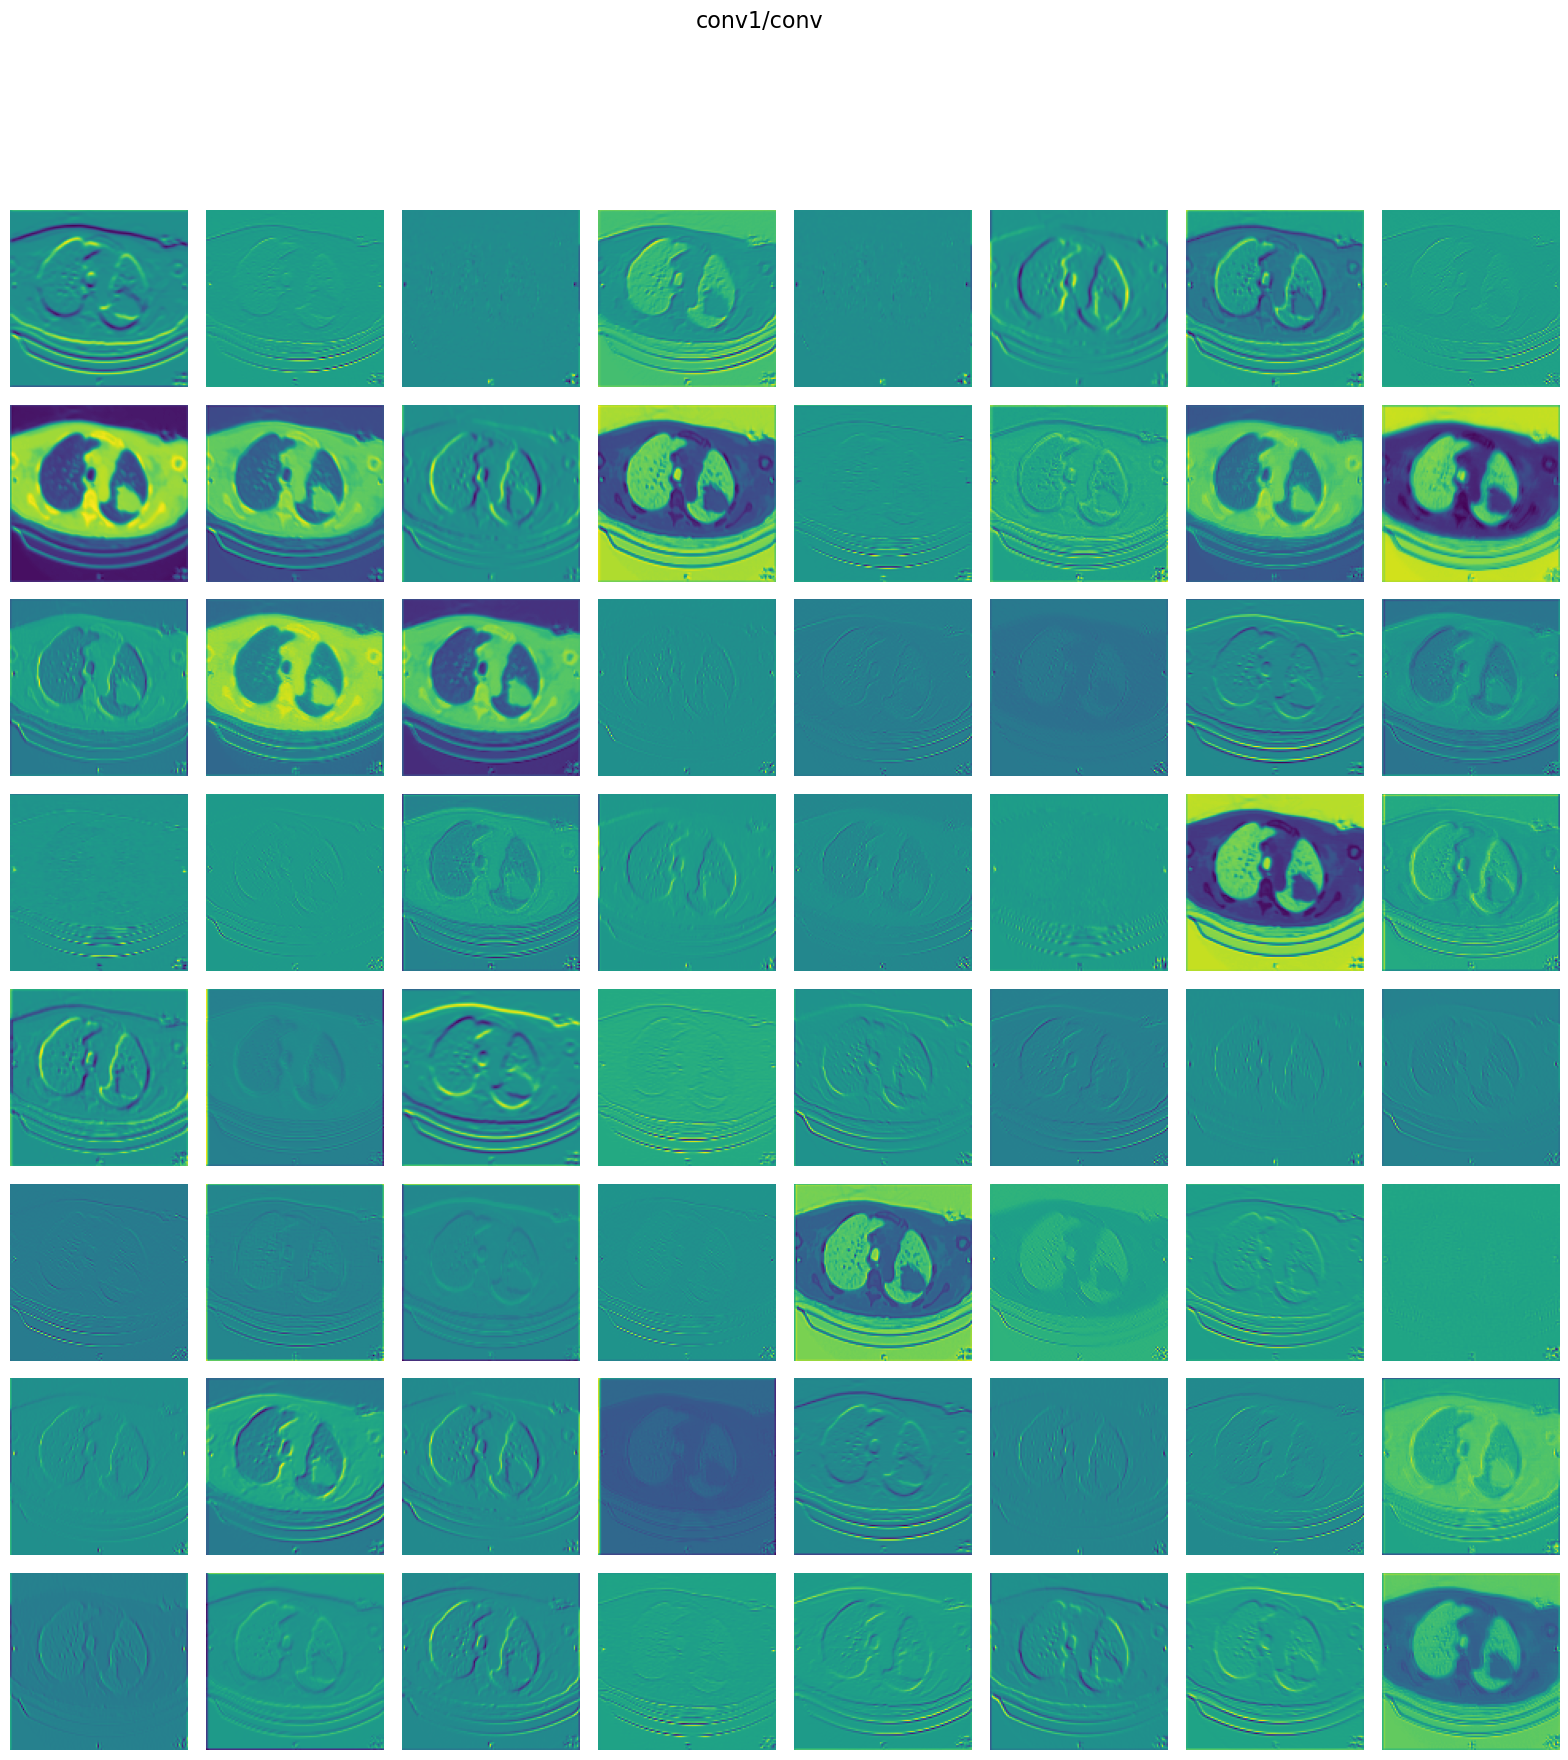

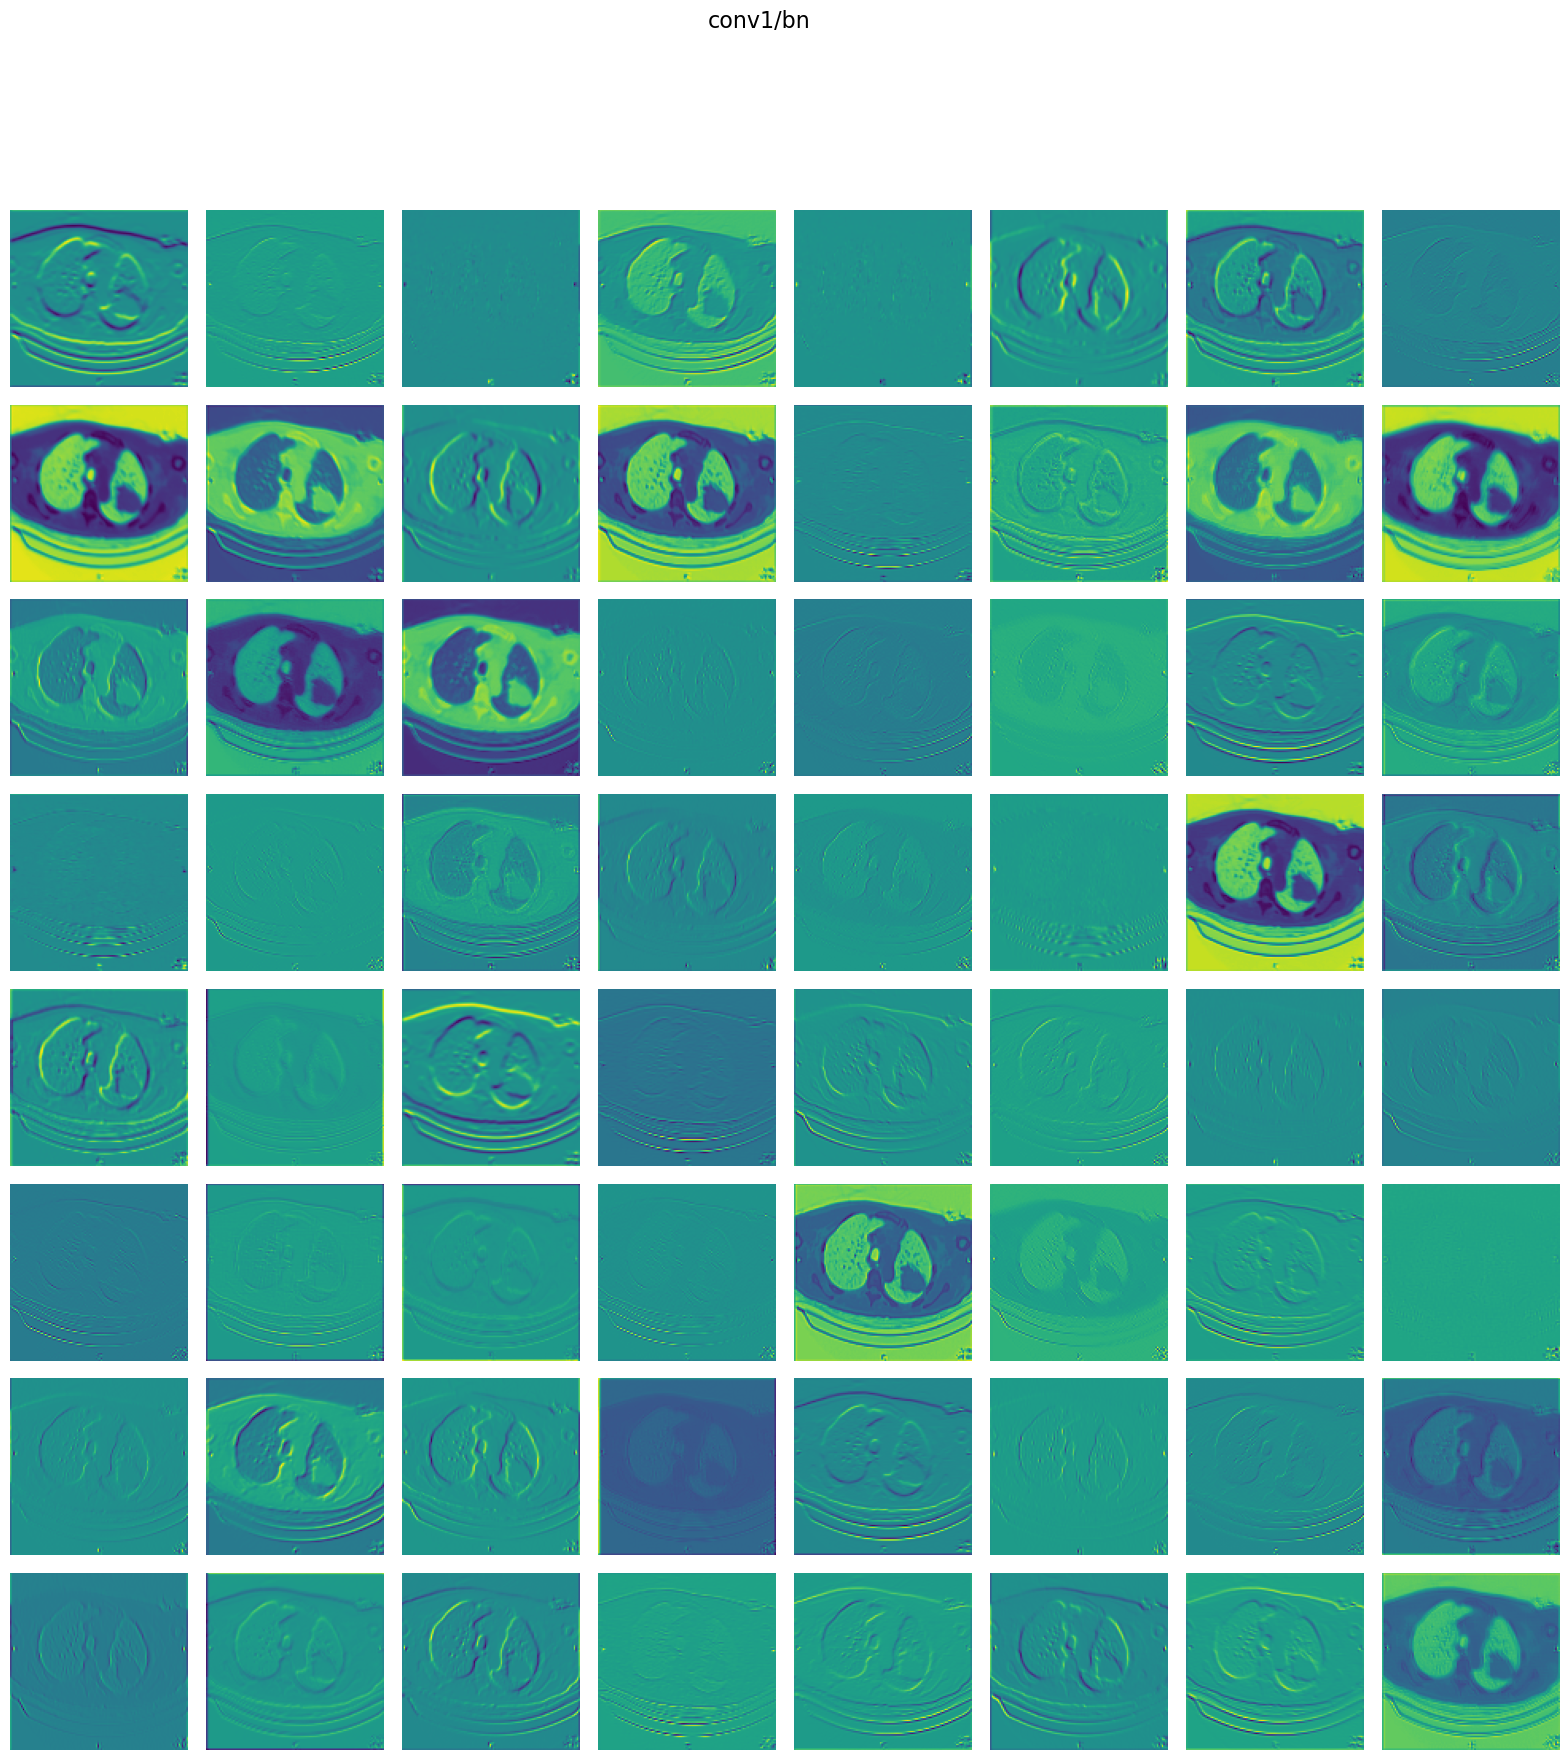

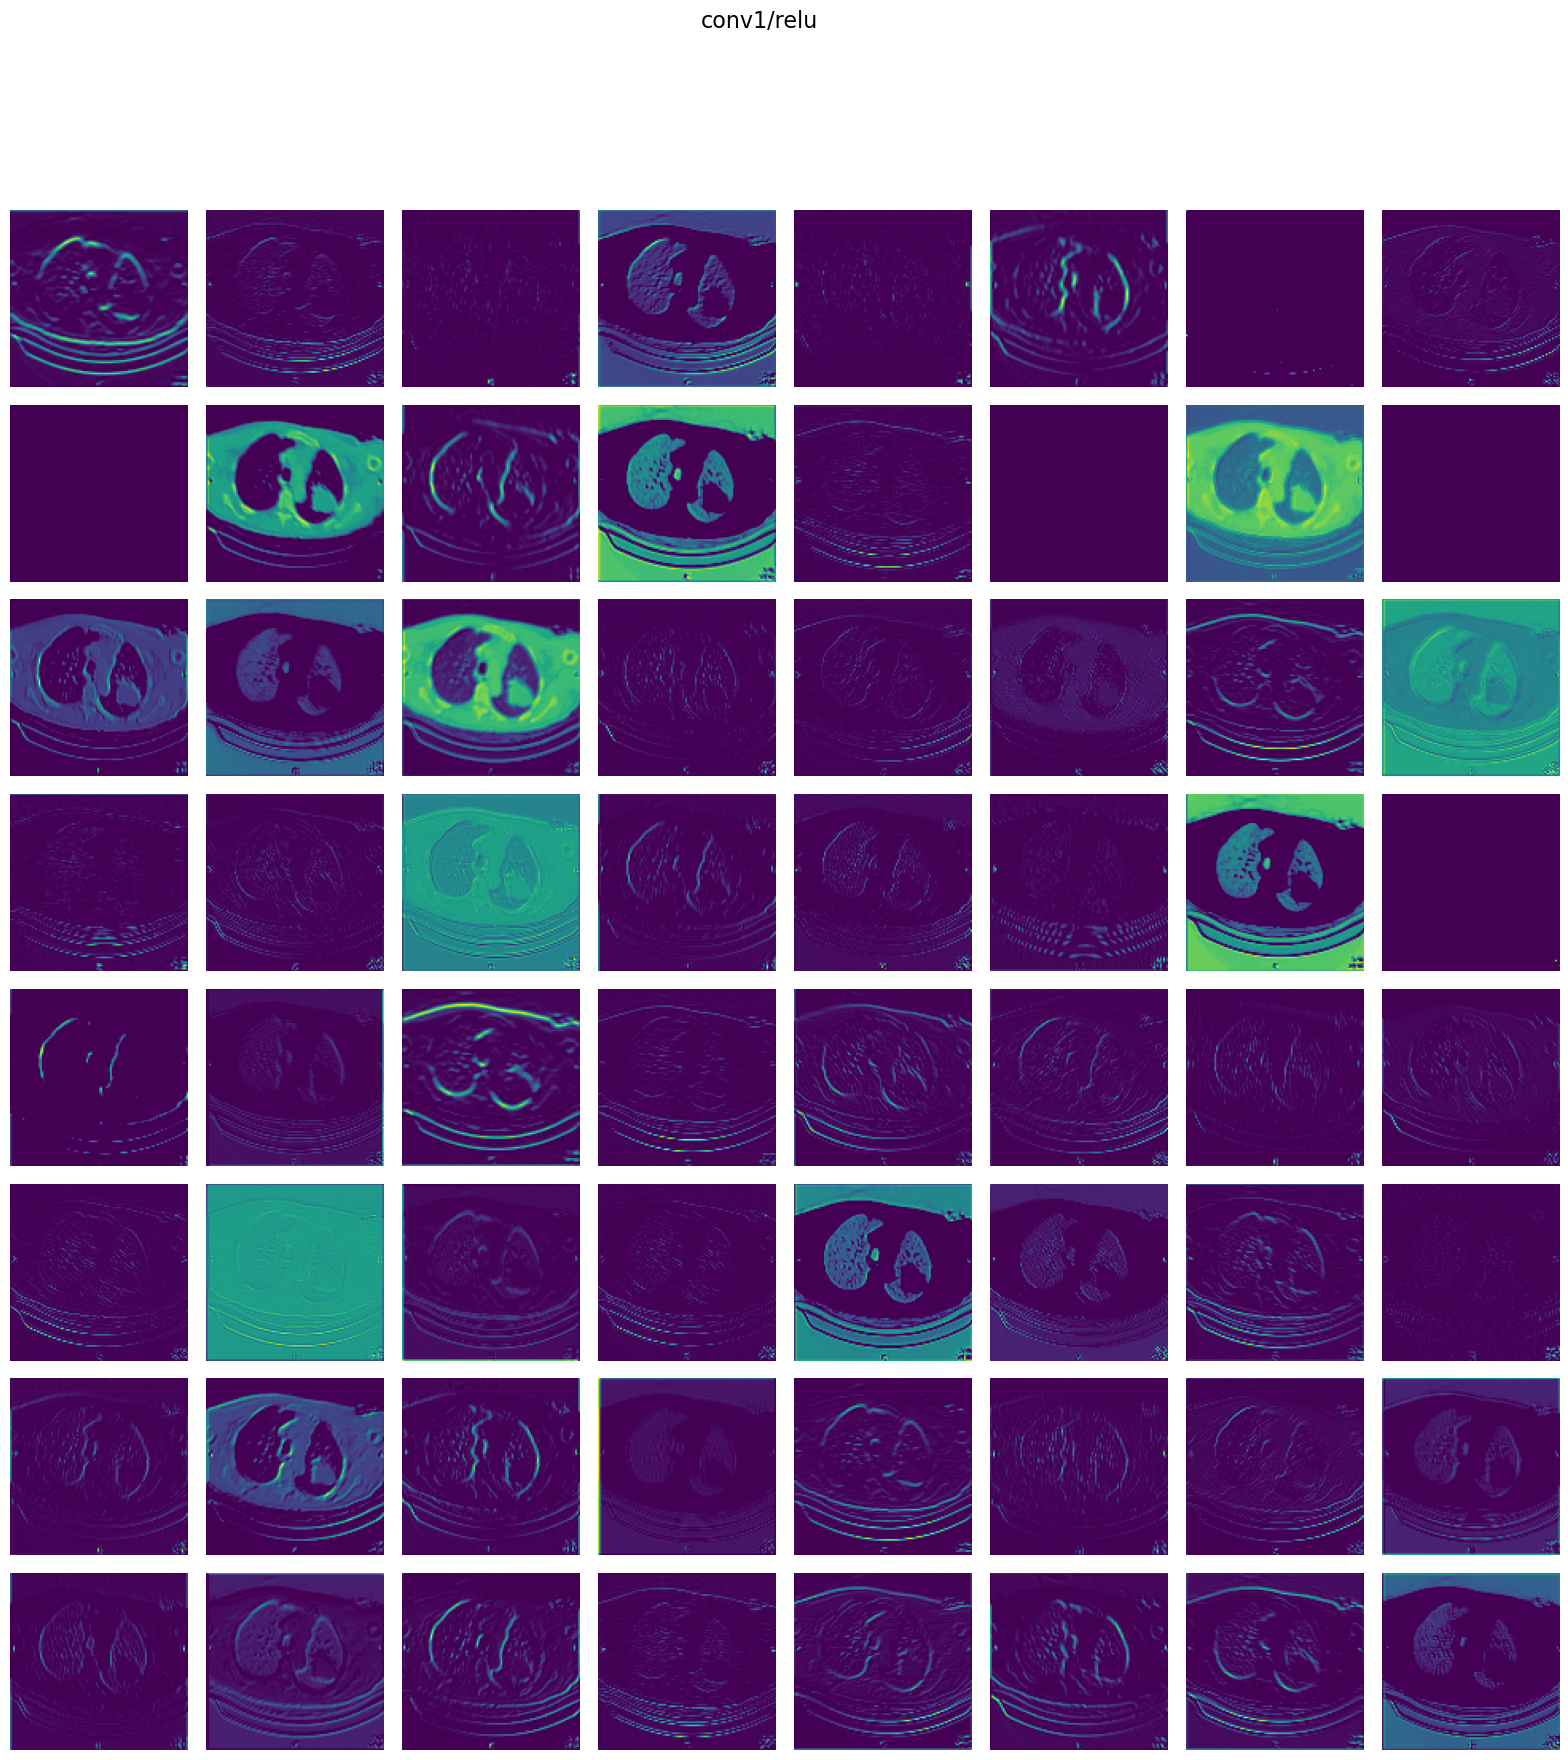

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input


base_model = DenseNet121(weights='imagenet', include_top=False)
# Choose the layers from which you want to extract feature maps
layer_names = [layer.name for layer in base_model.layers if 'conv1' in layer.name]
layers_output = [base_model.get_layer(name).output for name in layer_names]

# Create a new model that will output the feature maps from the chosen layers
feature_map_model = Model(inputs=base_model.input, outputs=layers_output)

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to extract feature maps
def extract_feature_maps(img_array):
    feature_maps = feature_map_model.predict(img_array)
    return feature_maps

# Function to visualize feature maps with 'viridis' colormap
def visualize_feature_maps_viridis(feature_maps, layer_names):
    for fmap, layer_name in zip(feature_maps, layer_names):
        num_feature_maps = fmap.shape[-1]
        size = fmap.shape[1]
        cols = 8  # Number of columns for subplot grid
        rows = num_feature_maps // cols + (num_feature_maps % cols > 0)
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
        fig.suptitle(layer_name, fontsize=16)

        for i in range(num_feature_maps):
            row = i // cols
            col = i % cols
            ax = axes[row, col]
            ax.axis('off')
            ax.imshow(fmap[0, :, :, i], cmap='viridis')

        for i in range(num_feature_maps, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

# Example usage
img_path = r'Pulmonary_adenocarcinoma,_left_lung,_CT_scan_Case_239_(7603361542).jpg'
img_array = load_and_preprocess_image(img_path)
feature_maps = extract_feature_maps(img_array)

# Visualize the feature maps with 'viridis' colormap
visualize_feature_maps_viridis(feature_maps, layer_names)


Sensitivity and Specificity for each class:
adenocarcinoma 
 Sensitivity (Recall): 0.7470,
 Specificity: 0.7246,
 Precision: 0.6200,
 Accuracy: 0.7330
large cell carcinoma 
 Sensitivity (Recall): 0.3488,
 Specificity: 0.9326,
 Precision: 0.5556,
 Accuracy: 0.8190
normal 
 Sensitivity (Recall): 0.9744,
 Specificity: 0.9780,
 Precision: 0.9048,
 Accuracy: 0.9774
squamous cell carcinoma 
 Sensitivity (Recall): 0.5536,
 Specificity: 0.8727,
 Precision: 0.5962,
 Accuracy: 0.7919

Average Sensitivity (Recall): 0.6559
Average Specificity: 0.8770
Average Precision: 0.6691
Average Accuracy: 0.8303


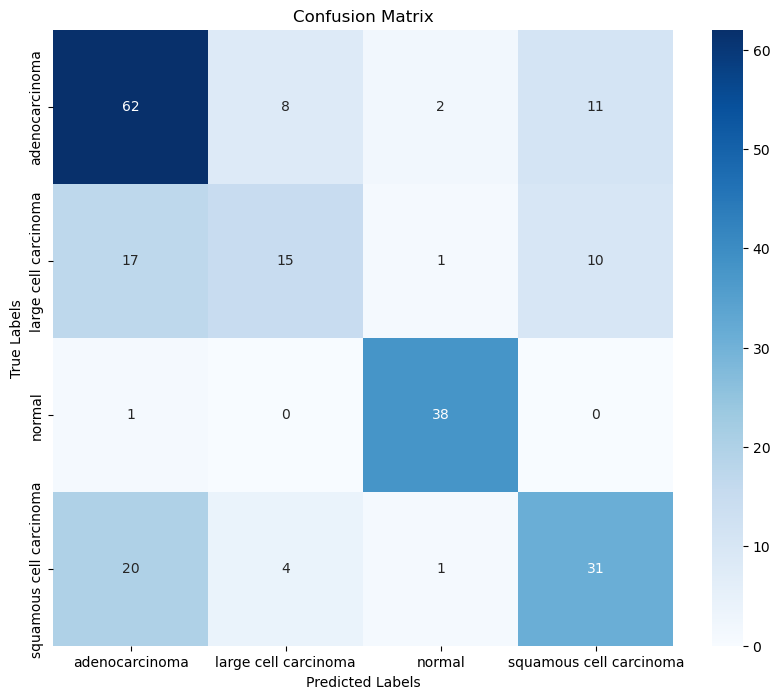


Overall Accuracy: 0.6606


In [7]:
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

class_nam = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']

# Fungsi untuk menghitung metrik
def calculate_metrics(cm):
    num_classes = cm.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    accuracy = np.zeros(num_classes)
    
    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        
        sensitivity[i] = tp / (tp + fn)
        specificity[i] = tn / (tn + fp)
        precision[i] = tp / (tp + fp)
        accuracy[i] = (tp + tn) / (tp + fn + fp + tn)
    
    return sensitivity, specificity, precision, accuracy

# Hitung metrik
sensitivity, specificity, precision, accuracy = calculate_metrics(cm)

print("Sensitivity and Specificity for each class:")
for i, class_name in enumerate(class_nam):
    print(f'{class_name} \n Sensitivity (Recall): {sensitivity[i]:.4f},\n Specificity: {specificity[i]:.4f},\n Precision: {precision[i]:.4f},\n Accuracy: {accuracy[i]:.4f}')

# Hitung rata-rata metrik per kelas
avg_sensitivity = np.mean(sensitivity)
avg_specificity = np.mean(specificity)
avg_precision = np.mean(precision)
avg_accuracy = np.mean(accuracy)

print(f'\nAverage Sensitivity (Recall): {avg_sensitivity:.4f}')
print(f'Average Specificity: {avg_specificity:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Accuracy: {avg_accuracy:.4f}')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_nam, yticklabels=class_nam)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Akurasi keseluruhan
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f'\nOverall Accuracy: {overall_accuracy:.4f}')


**DenseNet121**

In [ ]:
# Define custom preprocessing function
def custom_preprocessing(image):
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    norm = (grey / 255)
    imadapt = exposure.equalize_adapthist(norm, clip_limit=0.02)
    rgb = cv2.cvtColor(imadapt, cv2.COLOR_GRAY2BGR)
    return rgb

# Define path to data folders
train_data_dir = 'Data2/train'
validation_data_dir = 'Data2/valid'
test_data_dir = 'Data2/test'

# Define ImageDataGenerator for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    rotation_range = 10,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    #rescale=1./255  # Rescale pixel values to [0, 1]
    dtype= 'float32'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    #rescale=1./255
    dtype= 'float32'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    #rescale=1./255
    dtype= 'float32'
)

# Flow images from directories using ImageDataGenerator
#batch_size = 21
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle= False
)

#Model
def create_model(input_shape, num_classes):
    dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = dense_model.output
    
    # model = Sequential()
    # model.add(dense_model)
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(2,2))
    # #model.add(GlobalAveragePooling2D())
    # model.add(Flatten())
    # model.add(Dense(1024,activation = 'relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(512,activation = 'relu'))
    # #model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    # model.add(Dense(256,activation = 'relu'))
    # #model.add(Dense(128,activation = 'relu'))
    # model.add(Dense(num_classes,activation = 'softmax'))
    
    model = Sequential()
    model.add(dense_model)
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes,activation = 'softmax'))

    # Freeze pre-trained layers
    for layer in dense_model.layers:
        layer.trainable = False
        
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Create the transfer learning model
models = create_model(input_shape, num_classes)

models.summary()


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def custom_preprocessing(image):
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    norm = (grey / 255)
    imadapt = exposure.equalize_adapthist(norm, clip_limit=0.02)
    rgb = cv2.cvtColor(imadapt, cv2.COLOR_GRAY2BGR)
    return rgb
# Fungsi untuk membaca data dari direktori
def load_data_from_directory(data_dir):
    data = []
    labels = []
    classes = os.listdir(data_dir)
    
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
                    data.append(os.path.join(class_dir, filename))
                    labels.append(class_name)
    return data, labels


new_data_dir = 'DataGLCM'
data, labels = load_data_from_directory(new_data_dir)

df = pd.DataFrame({'filename': data, 'label': labels})
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

batch_size = 16

datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    dtype='float32'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    dtype='float32'
)

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

def create_model(input_shape, num_classes):
    dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()
    model.add(dense_model)
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    for layer in dense_model.layers:
        layer.trainable = False

    return model

input_shape = (224, 224, 3)
num_classes = 4

models = create_model(input_shape, num_classes)

models.summary()


Found 910 validated image filenames belonging to 4 classes.
Found 114 validated image filenames belonging to 4 classes.
Found 114 validated image filenames belonging to 4 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 1024)       4096      
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense

In [7]:
def model_size(model):
    # Save the model to a temporary file
    model.save('model/my_model_best10.h5')
    
    # Get the size of the file
    size = os.path.getsize('model/my_model_best10.h5')
    
    # Convert size to megabytes
    size_mb = size / (1024 * 1024)
    
    return size_mb

def params_size(params):
    # Calculate the size of the parameters in bytes
    total_size = 0
    for param in params:
        total_size += np.prod(param.shape) * param.dtype.size
    
    # Convert size to megabytes
    total_size_mb = total_size / (1024 * 1024)
    return total_size_mb

def summary_with_size(model):
    # Print the model summary
    model.summary()
    
    # Get the model size
    size_mb = model_size(model)
    
    # Calculate the size of trainable and non-trainable parameters
    trainable_size_mb = params_size(model.trainable_weights)
    non_trainable_size_mb = params_size(model.non_trainable_weights)
    
    # Print the size information
    total_params = model.count_params()
    trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
    non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])
    
    print(f"Total params: {total_params:,} ({size_mb:.2f} MB)")
    print(f"Trainable params: {trainable_params:,} ({trainable_size_mb:.2f} MB)")
    print(f"Non-trainable params: {non_trainable_params:,} ({non_trainable_size_mb:.2f} MB)")

input_shape = (224, 224, 3)
num_classes = 4

model = create_model(input_shape, num_classes)
summary_with_size(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 batch_normalization_25 (Bat  (None, 7, 7, 1024)       4096      
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 9216)              0         
                                                                 
 dense_25 (Dense)            (None, 1024)              9438208   
                                                                 
 batch_normalization_26 (Bat  (None, 1024)            

In [13]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#checkpointer = ModelCheckpoint('chestmodel.h5',verbose=1, save_best_only= True)
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.94:
            print("\nValidation accuracy reached 94%. Stopping training.")
            self.model.stop_training = True

def step_decay(epoch):
    if epoch < 125:
        lr = 0.001
    elif epoch < 175:
        lr = 0.0005
    else:
        lr = 0.00025
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

# Compile the model
# models.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
models.compile(optimizer= Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
result = models.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=[lr_scheduler]
)

Epoch 1/200
57/57 [==============================] - 24s 327ms/step - loss: 1.3078 - accuracy: 0.4341 - val_loss: 1.4630 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 2/200
57/57 [==============================] - 17s 297ms/step - loss: 1.0729 - accuracy: 0.4824 - val_loss: 1.6949 - val_accuracy: 0.3421 - lr: 0.0010
Epoch 3/200
57/57 [==============================] - 20s 343ms/step - loss: 1.0592 - accuracy: 0.5066 - val_loss: 0.9296 - val_accuracy: 0.5614 - lr: 0.0010
Epoch 4/200
57/57 [==============================] - 19s 326ms/step - loss: 1.0196 - accuracy: 0.5198 - val_loss: 0.9420 - val_accuracy: 0.5526 - lr: 0.0010
Epoch 5/200
57/57 [==============================] - 21s 367ms/step - loss: 0.9859 - accuracy: 0.5505 - val_loss: 0.8301 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 6/200
57/57 [==============================] - 19s 340ms/step - loss: 0.9498 - accuracy: 0.5758 - val_loss: 0.7589 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 7/200
57/57 [==============================] - 17s 3

8/8 [==============================] - 2s 144ms/step - loss: 0.2322 - accuracy: 0.9474
Test Loss: 0.23218819499015808
Test Accuracy: 0.9473684430122375


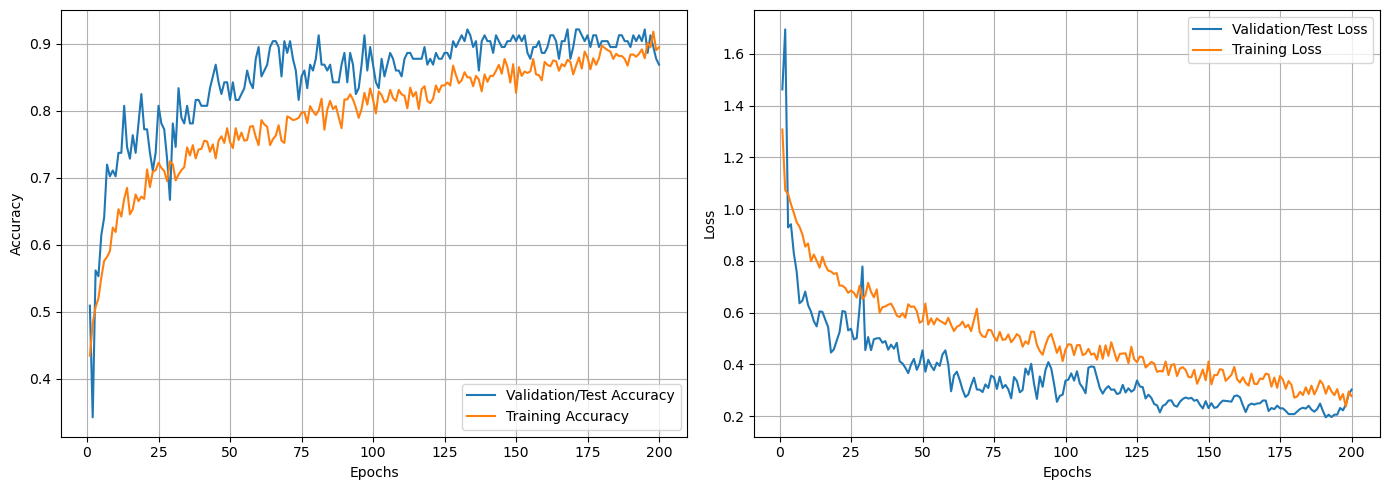

In [14]:
import matplotlib.pyplot as plt

test_loss, test_accuracy = models.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

res = result.history
train_acc = res['accuracy']
val_accuracy = res['val_accuracy']
epochs = range(1, len(train_acc) + 1)

train_loss = res['loss']
val_loss = res['val_loss']
epochs = range(1, len(train_loss) + 1)


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, label='Validation/Test Accuracy')
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, label='Validation/Test Loss')
plt.plot(epochs, train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

test_classes = os.listdir(test_data_dir)

predictions_prob = models.predict(test_generator)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_generator.classes

# Create confusion matrix
conf_matrix = confusion_matrix(true_label, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix ,fmt='g', annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation = 45)
plt.show()

# Print classification report
report = classification_report(true_label,predictions)
print(report)#, target_names=test_generator.class_indices.keys()))


8/8 [==============================] - 2s 202ms/step


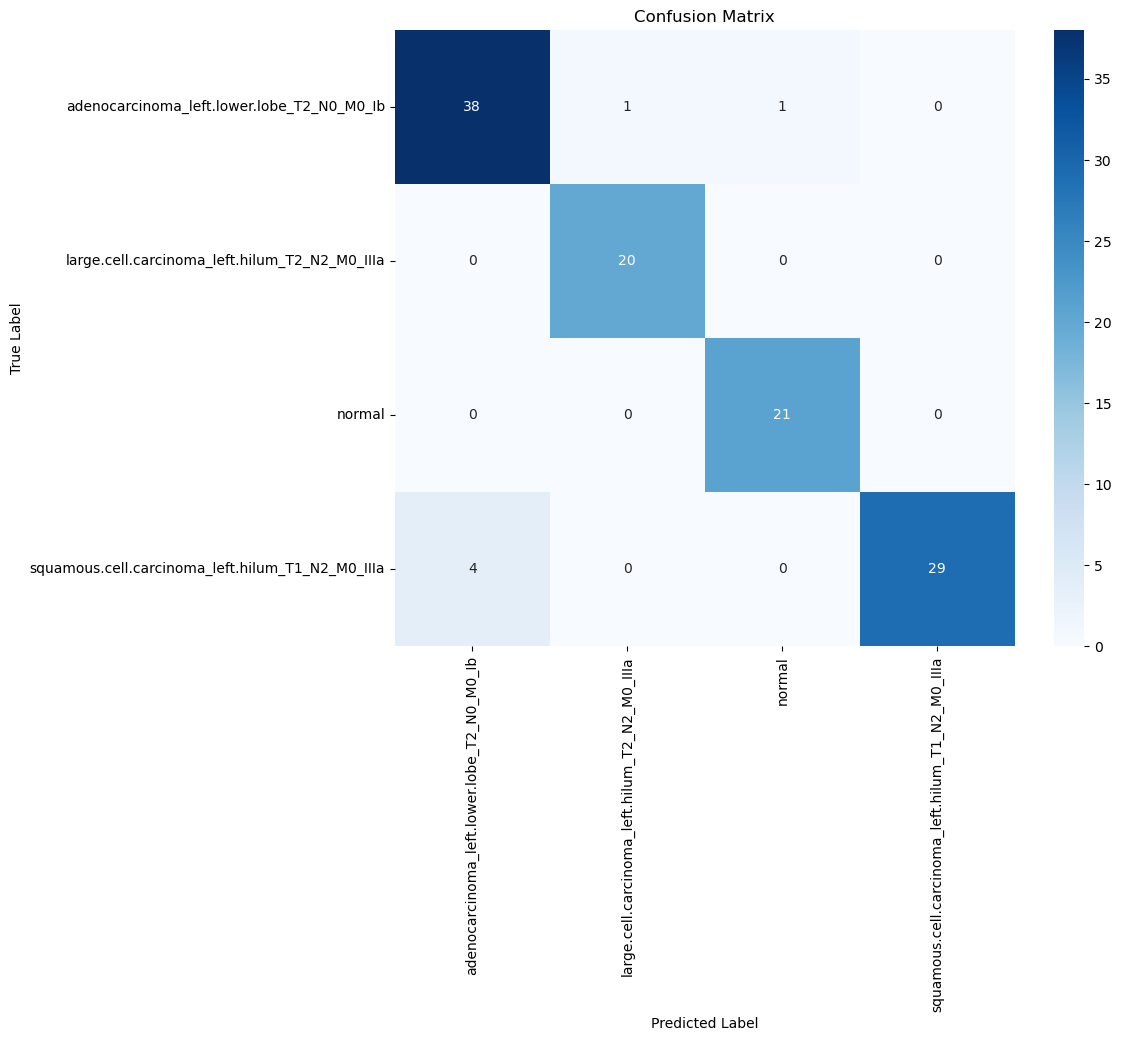


Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.90      0.95      0.93        40
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.95      1.00      0.98        20
                                          normal       0.95      1.00      0.98        21
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       1.00      0.88      0.94        33

                                        accuracy                           0.95       114
                                       macro avg       0.95      0.96      0.95       114
                                    weighted avg       0.95      0.95      0.95       114



In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi label dari generator data test
predictions = models.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Mengambil label sebenarnya
true_classes = test_generator.classes

# Membuat confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Mencetak classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_names)

# Plot confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(report)


In [18]:
class_name = os.listdir('DataGLCM')

cm = confusion_matrix(true_classes, predicted_classes)
def calculate_metrics(cm):
    num_classes = cm.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    accuracy = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    
    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        
        sensitivity[i] = tp / (tp + fn)
        specificity[i] = tn / (tn + fp)
        accuracy[i] = (tp+tn)/(tp+tn+fp+fn)
        precision[i] = tp/(tp+fp)
    
    return sensitivity, specificity, accuracy, precision

sensitivity, specificity, precision, accuracy = calculate_metrics(cm)
for i, class_name in enumerate(class_name):
    print(f'{class_name} \n Sensitivity (Recall): {sensitivity[i]:.4f}\n Specificity: {specificity[i]:.4f}\n Precision : {precision[i]:.4f}\n Accuracy : {accuracy[i]:.4f}')

# print(f'Accuracy: {accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall (Sensitivity): {sensitivity}')
# print(f'Specificity: {specificity}')


adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib 
 Sensitivity (Recall): 0.9500
 Specificity: 0.9459
 Precision : 0.9474
 Accuracy : 0.9048
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa 
 Sensitivity (Recall): 1.0000
 Specificity: 0.9894
 Precision : 0.9912
 Accuracy : 0.9524
normal 
 Sensitivity (Recall): 1.0000
 Specificity: 0.9892
 Precision : 0.9912
 Accuracy : 0.9545
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa 
 Sensitivity (Recall): 0.8788
 Specificity: 1.0000
 Precision : 0.9649
 Accuracy : 1.0000


In [ ]:
import os

# Assuming you have defined test_data_dir and test_generator previously

test_classes = os.listdir(test_data_dir)

# Get class indices for mapping class labels
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

predictions_prob = models.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)
true_labels = test_generator.classes

# Iterate through each image and print its prediction result
for i in range(len(predictions)):
    image_path = test_generator.filepaths[i]  # Get image path
    true_label = class_labels[true_labels[i]]  # Get true label
    predicted_label = class_labels[predictions[i]]  # Get predicted label
    
    print("Image:", image_path)
    print("True label:", true_label)
    print("Predicted label:", predicted_label)
    print()


In [16]:
test_classes = os.listdir('DataGLCM')

# Get class indices for mapping class labels
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

predictions_prob = models.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)
true_labels = test_generator.classes

# Iterate through each image and print its prediction result
for i in range(len(predictions)):
    image_path = test_generator.filepaths[i] 
    true_label = class_labels[true_labels[i]] 
    predicted_label = class_labels[predictions[i]] 
    
    print("Image:", image_path)
    print("True label:", true_label)
    print("Predicted label:", predicted_label)
    print()


8/8 [==============================] - 2s 241ms/step
Image: DataGLCM\normal\19 (2) - Copy.png
True label: normal
Predicted label: normal

Image: DataGLCM\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa\squamous-cell-carcinoma-of-the-lung-11 (8).jpg
True label: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
Predicted label: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa

Image: DataGLCM\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\pulmonary-adenocarcinoma-1 (3).png
True label: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Predicted label: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib

Image: DataGLCM\normal\7 (4).png
True label: normal
Predicted label: normal

Image: DataGLCM\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa\000081 (6).png
True label: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
Predicted label: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa

Image: DataGLCM\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa\squamous-cell-carcinoma-of-the-lung-8 (3).jpg
True label: squa

In [17]:
test_classes = os.listdir('DataGLCM')

# Get class indices for mapping class labels
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

predictions_prob = models.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)
true_labels = test_generator.classes

# Iterate through each image and print its prediction result
for i in range(len(predictions)):
    image_path = test_generator.filepaths[i]  # Get image path
    true_label = class_labels[true_labels[i]]  # Get true label
    predicted_label = class_labels[predictions[i]]  # Get predicted label
    
    if true_label != predicted_label:
        print("Image:", image_path)
        print("True label:", true_label)
        print("Predicted label:", predicted_label)
        print("Incorrect prediction")
        print()


8/8 [==============================] - 2s 207ms/step
Image: DataGLCM\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000160 (6).png
True label: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Predicted label: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
Incorrect prediction

Image: DataGLCM\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa\000135.png
True label: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
Predicted label: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Incorrect prediction

Image: DataGLCM\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\ad13.png
True label: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Predicted label: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
Incorrect prediction

Image: DataGLCM\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000035 (8).png
True label: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Predicted label: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
Incorrect prediction

Image: DataGLCM\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000017 (6).png
True label: ade

In [19]:
modelfile_name = 'model/my_model_best10.h5'
models.save(modelfile_name)

# Verify the file exists
if os.path.exists(modelfile_name):
    print("Model saved successfully!")
else:
    print("Error: Model file not found.")

Model saved successfully!
